# Cleaning anomalies in time series per region slug



## Load  libraries

In [1]:
# %load first_cell.py
%reload_ext autoreload
%autoreload 2
from pathlib import Path
home = str(Path.home())

import sys
sys.path = sys.path + [f'{home}/.conda/envs/norm_env/lib/python37.zip', 
                       f'{home}/.conda/envs/norm_env/lib/python3.7', 
                       f'{home}/.conda/envs/norm_env/lib/python3.7/lib-dynload', 
                       f'{home}/.conda/envs/norm_env/lib/python3.7/site-packages']
sys.prefix = '/home/soniame/.conda/envs/norm_env'

from paths import RAW_PATH, TREAT_PATH, OUTPUT_PATH, FIGURES_PATH

from copy import deepcopy
import numpy as np
import pandas as pd
pd.options.display.max_columns = 999
import yaml
import matplotlib.pyplot as plt 
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

# Plotting
import plotly
import plotly.graph_objs as go
import cufflinks as cf
plotly.offline.init_notebook_mode(connected=True)

def iplottitle(title, width=40):
    return '<br>'.join(textwrap.wrap(title, width))
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

import plotnine as p9
from mizani.breaks import date_breaks
from mizani.formatters import date_format
p9.theme_set(p9.theme_linedraw()) # default theme

# Setting cufflinks
import textwrap
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)
import yaml
from jinja2 import Template
cf.themes.THEMES['custom'] = yaml.load(open('cufflinks_template.yaml', 'r'))

# Manipulation 
from siuba import *

# Outliers
from adtk.data import validate_series
from adtk.transformer import DoubleRollingAggregate
from adtk.visualization import plot
from adtk.pipe import Pipeline
from adtk.detector import QuantileAD
from adtk.transformer import ClassicSeasonalDecomposition

## Load data

### dahsboard data

In [135]:
from src import utils

conn = utils.connect_athena(path='../configs/athena.yaml')
df = pd.read_sql_query("""
select 
    *,
    date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e') date
from spd_sdv_waze_corona.prod_daily_daily_index
where region_slug in ('country_mexico', 'country_brazil', 
    'mexicocity', 'riodejaneiro', 'saopaulo', 'torreon')
""", conn)

In [136]:
df.head(3)

,last_updated_utc,region_slug,region_name,country_name,country_iso_code,country_idb_code,region_type,population,timezone,year,month,day,dow,observed,expected_2020,ratio_20,tcp,dashboard,region_shapefile_wkt,date
0,2021-03-17 10:54:39.520,mexicocity,Ciudad de México,Mexico,MX,ME,city,22381714,America/Mexico_City,2020,11,6,5,152425044,226328826.0,0.673467,-32.653279,TRUE,Polygon ((-99.22541498771096258 19.79958548078...,2020-11-06
1,2021-03-17 10:54:39.520,mexicocity,Ciudad de México,Mexico,MX,ME,city,22381714,America/Mexico_City,2020,4,24,5,33724401,226328826.0,0.149006,-85.099379,TRUE,Polygon ((-99.22541498771096258 19.79958548078...,2020-04-24
2,2021-03-17 10:54:39.520,mexicocity,Ciudad de México,Mexico,MX,ME,city,22381714,America/Mexico_City,2020,7,3,5,90407653,226328826.0,0.399453,-60.054733,TRUE,Polygon ((-99.22541498771096258 19.79958548078...,2020-07-03


## Process creation

In [7]:
import numpy as np
import pandas as pd
from functools import reduce
from loguru import logger
from datetime import datetime, timedelta
from adtk.data import validate_series
from adtk.visualization import plot
from adtk.detector import LevelShiftAD, PersistAD, GeneralizedESDTestAD, SeasonalAD, AutoregressionAD
from tsmoothie.smoother import DecomposeSmoother


### Functions

In [251]:
def _validate_series(df, column_name):
    """
    A function to validate series
    
    Parameters
        ----------
        df : data frame 
            Data frame with column to validare. The data frame requires
            columns region_slug and date to be sorted. Date is defined as
            the index.
        column_name : str
            Name of the column to validate
    """

    logger.debug("... validating ...")
    y_df = df.sort_values(['date'])[['date', column_name]].set_index('date')
    s = validate_series(y_df)
    
    return s

#### Shift functions

In [697]:
### Shift functions

def _level_shift_detection(s, c_param = 6.0, window_param = 14, print_plot = False):
    """
    Level shift or change point detection. This function uses the function 
    LevelShiftAD from ADTK library.
    
    Parameters
    ----------
        s : validated serie object 
            Description
        c_param : dbl, default 6.0
            Description
        window_param : int, default 14
            Description
        print_plot: bool, default True
            Description
    """
    
    #logger.debug(f"... detecting shift c{c_param}-w{window_param}...")
    level_shift_ad = LevelShiftAD(c=c_param, side='both', window=window_param)
    anomalies = level_shift_ad.fit_detect(s)
    
    if print_plot:
        plot(s, anomaly=anomalies, anomaly_color='red')
    
    return anomalies

    
def _shifted_adtk_ts(s, column_name, agg="std", window=(3,3), diff="l2", print_plot=True):
    # shift ts level
    
    s_transformed = DoubleRollingAggregate(
        agg=agg,
        window=window,
        diff=diff).transform(s).rename(columns={column_name:'adtk_shift'})
    
    if print_plot:
        plot(pd.concat([s, s_transformed], axis=1))
        
    return s_transformed
                
def _shift_ts(shift_init, date_column, to_shift_column):
    
    # a two weeks both sided window
    shift_wdw_init = shift_init - timedelta(days=14)
    shift_wdw_end  = shift_init + timedelta(days=14)
    # level centered
    center_point = ((to_shift_column[(date_column >  shift_wdw_init) & 
                        (date_column <= shift_init)].mean()) -
                    (to_shift_column[(date_column >  shift_init) & 
                        (date_column <= shift_wdw_end)].mean())
                   )
    # change print to logger
    logger.debug(center_point)
    shifted_column = to_shift_column
    shifted_column[ (date_column > shift_init) ] = \
        ( (to_shift_column[(date_column > shift_init)]) + center_point )
        
    return shifted_column    

def _shift_sum(df_shift):
    df_shift_sum = (df_shift.reset_index()
     >> filter(_.date > '2020-03-31')
     >> gather('variable', 'value', -_.date)
     >> group_by('date')
     >> summarize(shift_sum = _.value.sum())
     >> filter(_.shift_sum > 0)
     >> arrange('date')
    )

    return df_shift_sum

def _initial_shift_date(df_shift_sum):

    shift_init = df_shift_sum[df_shift_sum.shift_sum == df_shift_sum.shift_sum.max()].date.min()
    
    return shift_init


def _shift_level_report(df_shift, df_shift_sum, observed_column):
    
    df_shift=df_shift.reset_index()    
    df_shift['observed_column'] = observed_column
    df_gather = (df_shift
         >> gather('variable', 'value', -_['date', 'observed_column']) 
       )   
    tab = (df_gather
         >> mutate(value_rec = _.value.replace( 0, np.nan))
        )
    tab[['shift', 'cparam', 'window']] = tab['variable'].str.split('_',expand=True)
    gg = (p9.ggplot(tab, p9.aes(x ='date', y = 'observed_column'))
     + p9.geom_line(size = 1) 
     + p9.geom_point(p9.aes(size = 'value_rec', color = 'value_rec')) 
     + p9.facet_grid('window ~ cparam')
     + p9.scale_size_continuous(range=(1.5, 1.5)) 
     + p9.theme(axis_text_x=p9.element_text(angle=90),
                figure_size=(8, 6) )
        )
    print(gg)

    #logger.debug(df_shift_sum)
    
    gg = (p9.ggplot(df_shift_sum, p9.aes(x ='date', y = 'shift_sum'))
     + p9.geom_col()
     + p9.theme(axis_text_x=p9.element_text(angle=90),
                figure_size=(8, 2) )
        )
    print(gg)
    logger.debug(df_shift_sum[df_shift_sum.shift_sum == df_shift_sum.shift_sum.max()])
    
    
def _run_shift_grid(s, observed_variable, c_param, low_grid = .20, upp_grid = .60):
    
    shift_l = list()
    for cp in [round(c_param-c_param*(upp_grid), 4), 
               round(c_param-c_param*(low_grid), 4), 
               c_param, 
               round(c_param+c_param*(low_grid), 4), 
               round(c_param+c_param*(upp_grid), 4) ]:
        for wdw in [14, 15, 16, 17, 18]:    
            shift = _level_shift_detection(s, c_param = cp,
                                           window_param=wdw, 
                                           print_plot = False) \
                    .rename(columns={observed_variable:f'shift_c{cp}_w{wdw}'})
            shift_l.append(shift)
    len(shift_l)    
    df_grid = reduce(lambda df1, df2: df1.merge(df2, on='date'), shift_l)
    df_grid.shape
    
    return df_grid


def _shift_level(df, 
                 column_name, 
                 c_param  = c_param, 
                 low_grid = .20, 
                 upp_grid = .60, 
                 print_plot   = False,
                 print_report = False):

    s = _validate_series(df.reset_index(), column_name=column_name)
    plot(s)
    
    # running grid
    df_grid = _run_shift_grid(s, 
                            observed_variable = column_name,
                            c_param  = c_param, 
                            low_grid = low_grid, 
                            upp_grid = upp_grid)
    # grid summary
    df_grid_sum = _shift_sum(df_grid)
    # first date
    shift_init  = _initial_shift_date(df_grid_sum)
    # center shift ts
    shifted_column = _shift_ts(shift_init  = shift_init,
                               date_column = df.date,
                               to_shift_column = df[column_name])
    if print_plot:
        _plot_levelshift(df_grid, observed_column = df[column_name])
    
    if print_report:
        _shift_level_report(df_grid, 
                            df_grid_sum,
                            observed_column=s.reset_index()[column_name])
    
    return shifted_column


#### Anomalies functions

In [646]:
### Outlier functions
def _outlier_persist_ad(s, c_param = 4, window_param = 14):
    persist_ad = PersistAD(c=c_param, side='both', window = window_param)
    #persist_ad.window = 14
    anomalies = persist_ad.fit_detect(s)

    return(anomalies)

def _outlier_gesdt_ad(s, alpha_param = 0.3, window_param = 14):
    esd_ad = GeneralizedESDTestAD(alpha=alpha_param)
    anomalies = persist_ad.fit_detect(s)

    return(anomalies)

def _outlier_seasonal_ad(s, c_param = 3.0, window_param = 14):
    seasonal_ad = SeasonalAD(c=c_param, side="both")
    anomalies = seasonal_ad.fit_detect(s)

    return(anomalies)

def _outlier_autregr_ad(s, c_param = 3.0, n_steps_param = 4, step_size_param=7):
    autoregression_ad = AutoregressionAD(n_steps=n_steps_param, step_size=step_size_param, c=c_param)
    anomalies = autoregression_ad.fit_detect(s)
    
    return(anomalies)

def _anomalies_detector(s, target_column_name):
    anomalies = _outlier_persist_ad(s) \
        .rename(columns={target_column_name:'anomaly_persist'}) \
        .reset_index() \
        .merge(_outlier_seasonal_ad(s) \
               .rename(columns={target_column_name:'anomaly_seasonal'}) \
               .reset_index()) \
        .merge(_outlier_autregr_ad(s) \
               .rename(columns={target_column_name:'anomaly_autor'}) \
               .reset_index()) \
        .fillna(0)
    
    anomalies['anomaly_sum'] = \
        (anomalies['anomaly_persist']) + \
        (anomalies['anomaly_seasonal'] == True) +  \
        (anomalies['anomaly_autor'])
    anomalies.head(2)
    
    return(anomalies[anomalies.anomaly_sum > 0])


# 2. Find anomalies
def _find_anomalies(df, anomaly_vote_minimun, target_column_name, print_plot=True):

    # validate series
    s = _validate_series(df, target_column_name)
    plot(s)
    
    # join anomialies detector
    df_anomaly = df.merge(_anomalies_detector(s, target_column_name), how = 'left')
    anomalies_cnt = sum(df_anomaly.anomaly_sum >= anomaly_vote_minimun)
    
    logger.debug('Anomalies found: ' + str(anomalies_cnt))  
    logger.debug(df_anomaly.shape)
    
    if print_plot:
        logger.debug(df_anomaly.columns)
        print(_plot_anomalies(df_anomaly, observed_column = target_column_name))
    
    return(df_anomaly)


#### Imputation functions

In [571]:
### Imputation functions
def _decompose_lowess(variable_smooth, missing_values, smooth_fraction=0.2):
    # operate smoothing
    # variable_smooth = (df_imputate.obs_shifted)
    smoother = DecomposeSmoother(smooth_type='lowess', periods=7,
                             smooth_fraction=smooth_fraction)
    smoother.smooth(variable_smooth)

    result = variable_smooth
    smooth_result = smoother.smooth_data[0]
    result[missing_values] = smooth_result[missing_values]
    
    return result

# 3. Impute anomalies
def _impute_anomalies(observed_column, date_column, anomaly_sum_column, 
                      anomaly_vote_minimun, print_plot = True):
    
    df_impute = pd.DataFrame({
        'date': date_column,
        'observed_column': observed_column,
        'anomaly_sum': anomaly_sum_column,
        'observed_missing': observed_column
    }) 
    df_impute.observed_missing[df_impute.anomaly_sum >= anomaly_vote_minimun] = None
    df_impute.observed_missing[df_impute.observed_column < 0] = None
    df_impute = df_impute.set_index('date')
    

    df_impute =  df_impute \
        .assign(RollingMean=df_impute.observed_missing \
                    .fillna(df_impute.observed_missing \
                            .rolling(30, min_periods=1,) \
                            .mean()) ) \
        .assign(RollingMedian=df_impute.observed_missing \
                    .fillna(df_impute.observed_missing \
                            .rolling(30, min_periods=1,) \
                            .median()) ) \
        .assign(Polinomial=df_impute.observed_missing \
                    .interpolate(method='polynomial', order = 5)) \
        .assign(Loess=_decompose_lowess(df_impute.observed_column, 
                                        df_impute.observed_missing.isna())) 

    logger.debug(df_impute.shape)
    
    if print_plot:
        logger.debug(df_impute.columns)
        print(_plot_imputation(df_impute))

    return df_impute


#### Plot functions

In [567]:
### Plot functions
def _plot_levelshift(df_shift, observed_column):
    gg = (p9.ggplot(data=df_shift,
               mapping=p9.aes(x='date', y=observed_column)) 
        + p9.geom_line(size = 1) 
        + p9.geom_line(p9.aes(y = 'obs_shifted'), size = 1, color = "red") 
        + p9.labs(title='Level Shift')
         )
    return gg
    
def _plot_anomalies(df_anomaly, observed_column):
    gg = (p9.ggplot(data=df_anomaly,
               mapping=p9.aes(x='date', y=observed_column)) 
        + p9.geom_line(size = 1) 
        + p9.geom_point(p9.aes(size = 'anomaly_sum', color ='anomaly_sum') )
        + p9.labs(title='Anomalies identification') 
        + p9.theme(figure_size=(6, 3))
         )
    return gg
    
def _plot_imputation(df_imputate):
    gg = (p9.ggplot(data=df_imputate.reset_index(),
           mapping=p9.aes(x='date', y='observed_column')) 
        + p9.geom_line(color = 'gray') 
        + p9.geom_line(p9.aes(y = 'RollingMean'), color = "red", alpha = .4) 
        + p9.geom_line(p9.aes(y = 'Polinomial'), color = "green", alpha = .4) 
        + p9.geom_line(p9.aes(y = 'RollingMedian'), color = "blue", alpha = .4)
        + p9.geom_line(p9.aes(y = 'Loess'), color = "black") 
        + p9.labs(title='Imputation of anomalies')
        + p9.theme(figure_size=(6, 3))
         )    
    return gg

#### Process functions

In [672]:
### run functions
def _run_step(df_run, target_column_name, output_column_name):

    df_anomaly = _find_anomalies(df_run, 
                                 anomaly_vote_minimun = 1, 
                                 target_column_name = target_column_name,
                                 print_plot = True)

    df_output  = _impute_anomalies(observed_column = df_anomaly[target_column_name], 
                                  date_column = df_anomaly.date, 
                                  anomaly_sum_column = df_anomaly.anomaly_sum, 
                                  anomaly_vote_minimun = 1, 
                                  print_plot = True).reset_index()

    df_output[output_column_name] = _shift_level(df_output, 
                                        column_name='Loess', 
                                        c_param = c_param, 
                                        low_grid = .20, 
                                        upp_grid = .60,
                                        print_report = True)

    df_output.columns
    
    return df_output

def _run_cleaning(df, observed_variable, anomaly_vote_minimun):
    
    # 0. Parameter calculation
    
    # 1. Shift level
    df_shift   = _shift_level(df, observed_variable = 'observed', c_param=5.0)

    # 2. Find anomalies
    df_anomaly = _find_anomalies(df_shift, anomaly_vote_minimun = 1)

    # 3. Impute anomalies
    df_impute  = _impute_anomalies(df_anomaly, anomaly_vote_minimun = 1)
    
    return df_shift

In [320]:

# (Deprecated)
#def _shifted_ts(shift, column_name, df):
#    # shift ts level
#    
#    logger.debug("... centering shift ...")
#    # shift level happening
#    shift_init = shift[shift[column_name] == 1].date.min()
#    
#    # a two weeks both sided window
#    shift_wdw_init = shift_init - timedelta(days=14)
#    shift_wdw_end  = shift_init + timedelta(days=14)
#
#    # level centered
#    center_point = ((df[(df['date'] >  shift_wdw_init) & 
#                        (df['date'] <= shift_init)].observed.mean()) -
#                    (df[(df['date'] >  shift_init) & 
#                        (df['date'] <= shift_wdw_end)].observed.mean())
#                   )
#
#    # change print to logger
#    print(center_point)
#
#    df['obs_shifted'] = df[column_name]
#    df['obs_shifted'][(df['date'] > shift_init)] = \
#        ((df[column_name][(df['date'] > shift_init)]) + 
#          center_point)
#
#    return df, shift_init
#    

In [15]:
df.date.min()

Timestamp('2020-03-09 00:00:00')

### Running one region slug

In [ ]:
#tt = _run_cleaning(df[df.region_slug == 'mexicocity'], 
#                 observed_variable = 'observed', 
#                 anomaly_vote_minimun = 1)

#(tt[['date', 'dow', 'observed', 'obs_shifted']][(tt.date >= '2020-07-07') & (tt.date <= '2020-07-30') | (tt.date >= '2020-12-07') & (tt.date <= '2021-01-10')]
# >> mutate(obs_shifted = _.obs_shifted/1000,
#          observed = _.observed/1000)
# >> arrange('date')
#).head()

### Running per region

In [ ]:
### run for each region
#for region in df.region_slug.unique():
#    print(f"... region_slug {region} ...")
#    
#    run_cleaning(df[df.region_slug == region], 
#                 observed_variable = 'observed', 
#                 anomaly_vote_minimun = 1)    

### Testing

In [532]:
region_slug = 'mexicocity'

In [533]:
df_cty = df[df.region_slug == region_slug]

In [534]:
c_region = pd.read_csv('/home/soniame/shared/spd-sdv-omitnik-waze/corona/raw/cities_c_iqr.csv') \
    .rename(columns={'city':'region_slug'})
# TODO: maximo de p's
c_param = c_region[c_region.region_slug == region_slug].c_low_p1.to_list()[0]
logger.debug('c_param: ' + str(c_param))

2021-03-17 21:26:59.662 | DEBUG    | __main__:<module>:5 - c_param: 1.222


In [536]:
gg=(p9.ggplot(data=df_cty.reset_index(),
           mapping=p9.aes(x='date', y='observed')) 
        + p9.geom_line(color = 'gray'))
#gg

#### First run

2021-03-18 00:36:11.173 | DEBUG    | __main__:_validate_series:15 - ... validating ...
2021-03-18 00:36:11.295 | DEBUG    | __main__:_find_anomalies:59 - Anomalies found: 16
2021-03-18 00:36:11.296 | DEBUG    | __main__:_find_anomalies:60 - (373, 24)
2021-03-18 00:36:11.297 | DEBUG    | __main__:_find_anomalies:63 - Index(['last_updated_utc', 'region_slug', 'region_name', 'country_name',
       'country_iso_code', 'country_idb_code', 'region_type', 'population',
       'timezone', 'year', 'month', 'day', 'dow', 'observed', 'expected_2020',
       'ratio_20', 'tcp', 'dashboard', 'region_shapefile_wkt', 'date',
       'anomaly_persist', 'anomaly_seasonal', 'anomaly_autor', 'anomaly_sum'],
      dtype='object')


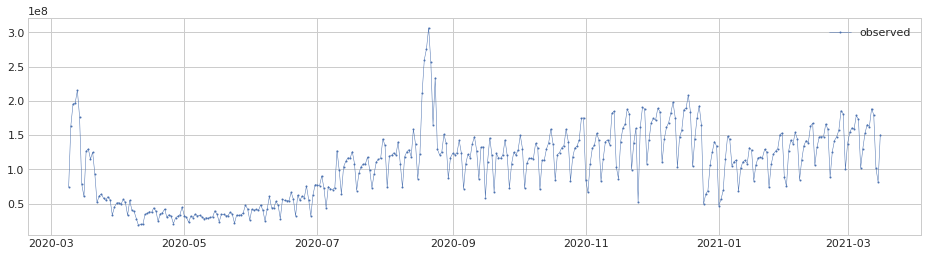

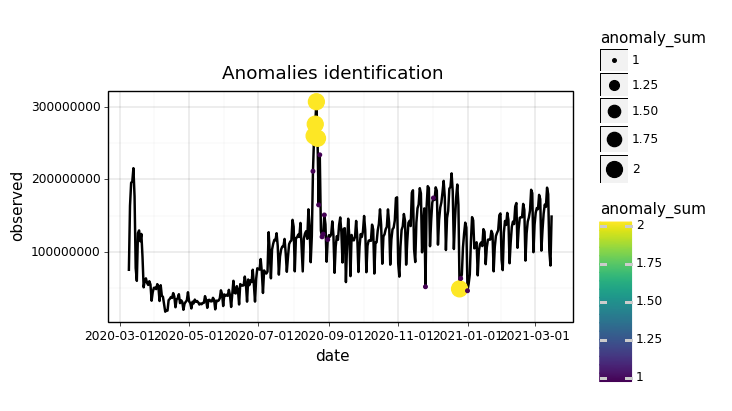

2021-03-18 00:36:12.034 | DEBUG    | __main__:_impute_anomalies:44 - (373, 7)
2021-03-18 00:36:12.035 | DEBUG    | __main__:_impute_anomalies:47 - Index(['observed_column', 'anomaly_sum', 'observed_missing', 'RollingMean',
       'RollingMedian', 'Polinomial', 'Loess'],
      dtype='object')


<ggplot: (8772110131749)>


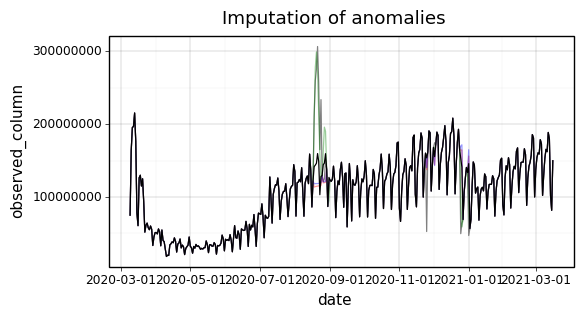

2021-03-18 00:36:12.561 | DEBUG    | __main__:_validate_series:15 - ... validating ...


<ggplot: (8772112126685)>


2021-03-18 00:36:13.536 | DEBUG    | __main__:_shift_ts:55 - 48234693.14285715


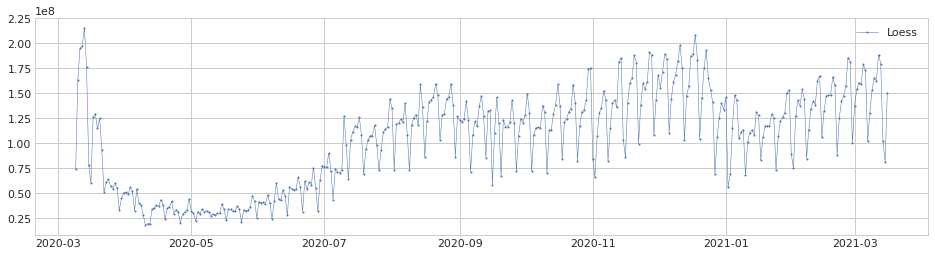

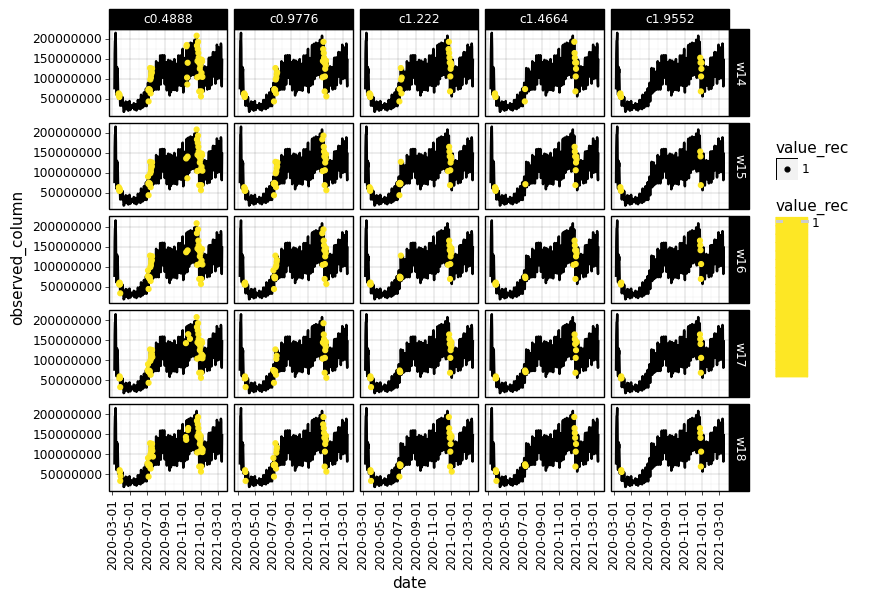

2021-03-18 00:36:25.060 | DEBUG    | __main__:_shift_level_report:102 -           date  shift_sum
91  2020-07-01        1.0
92  2020-07-02        3.0
93  2020-07-03        6.0
94  2020-07-04        7.0
95  2020-07-05       14.0
96  2020-07-06       19.0
97  2020-07-07       18.0
98  2020-07-08       15.0
99  2020-07-09       13.0
100 2020-07-10       13.0
101 2020-07-11        9.0
102 2020-07-12       10.0
103 2020-07-13       11.0
104 2020-07-14       10.0
105 2020-07-15        9.0
106 2020-07-16        7.0
107 2020-07-17        6.0
108 2020-07-18        2.0
110 2020-07-20        1.0
224 2020-11-11        2.0
225 2020-11-12        3.0
226 2020-11-13        1.0
227 2020-11-14        1.0
228 2020-11-15        1.0
229 2020-11-16        2.0
230 2020-11-17        3.0
231 2020-11-18        1.0
232 2020-11-19        2.0
238 2020-11-25        1.0
261 2020-12-18        4.0
262 2020-12-19        7.0
263 2020-12-20       12.0
264 2020-12-21        7.0
265 2020-12-22        7.0
266 2020-12-23    

<ggplot: (8772113537421)>


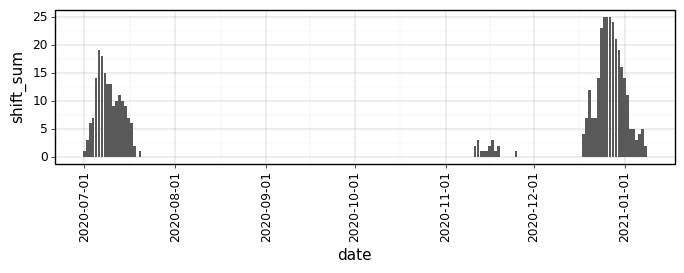

2021-03-18 00:36:25.982 | DEBUG    | __main__:_shift_level_report:112 -           date  shift_sum
268 2020-12-25       25.0
269 2020-12-26       25.0
270 2020-12-27       25.0


<ggplot: (8772111718717)>


In [678]:
df_run_1 = _run_step(df_run = df_cty.sort_values(by=['region_slug', 'date']),
                     target_column_name = 'observed',
                     output_column_name = 'shift_1')

#### Second run

2021-03-18 00:38:13.717 | DEBUG    | __main__:_validate_series:15 - ... validating ...
2021-03-18 00:38:13.836 | DEBUG    | __main__:_find_anomalies:59 - Anomalies found: 6
2021-03-18 00:38:13.836 | DEBUG    | __main__:_find_anomalies:60 - (373, 6)
2021-03-18 00:38:13.837 | DEBUG    | __main__:_find_anomalies:63 - Index(['date', 'shift_1', 'anomaly_persist', 'anomaly_seasonal',
       'anomaly_autor', 'anomaly_sum'],
      dtype='object')


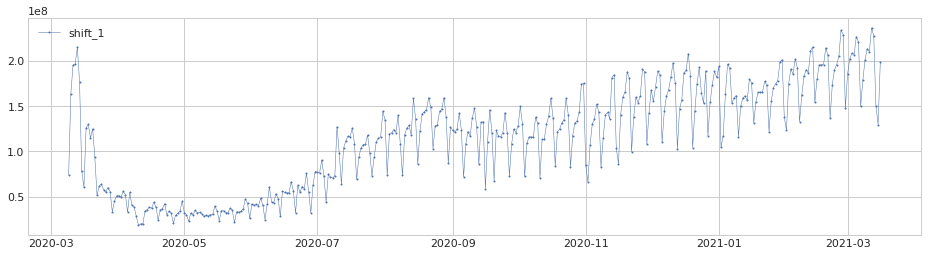

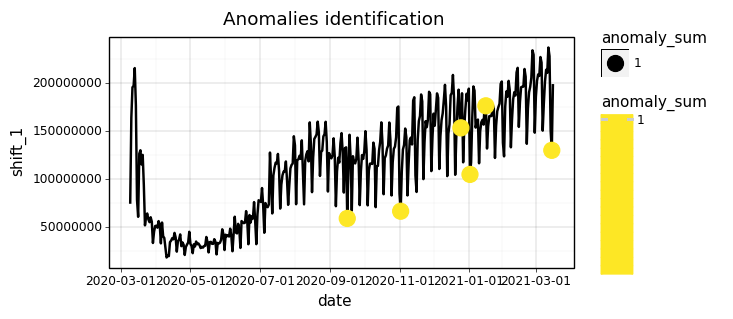

2021-03-18 00:38:14.575 | DEBUG    | __main__:_impute_anomalies:44 - (373, 7)
2021-03-18 00:38:14.576 | DEBUG    | __main__:_impute_anomalies:47 - Index(['observed_column', 'anomaly_sum', 'observed_missing', 'RollingMean',
       'RollingMedian', 'Polinomial', 'Loess'],
      dtype='object')


<ggplot: (8772118541449)>


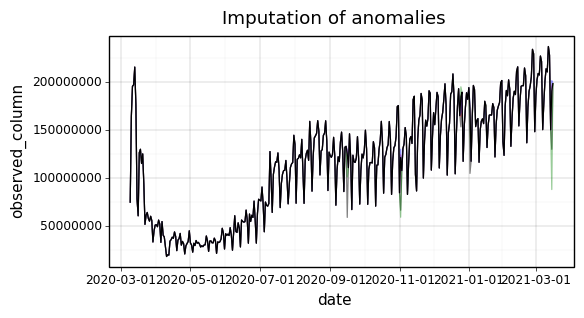

2021-03-18 00:38:15.119 | DEBUG    | __main__:_validate_series:15 - ... validating ...


<ggplot: (8772112940573)>


2021-03-18 00:38:16.082 | DEBUG    | __main__:_shift_ts:55 - -31277864.500000007


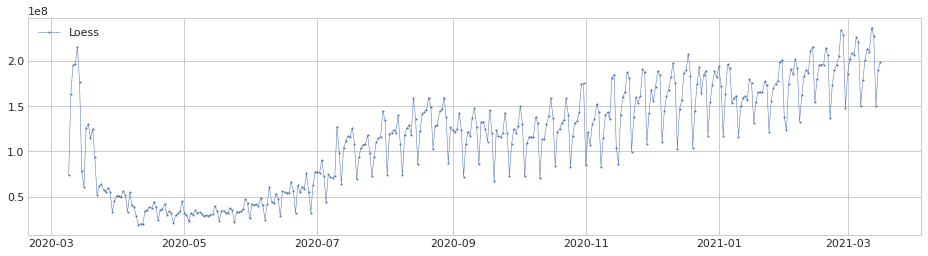

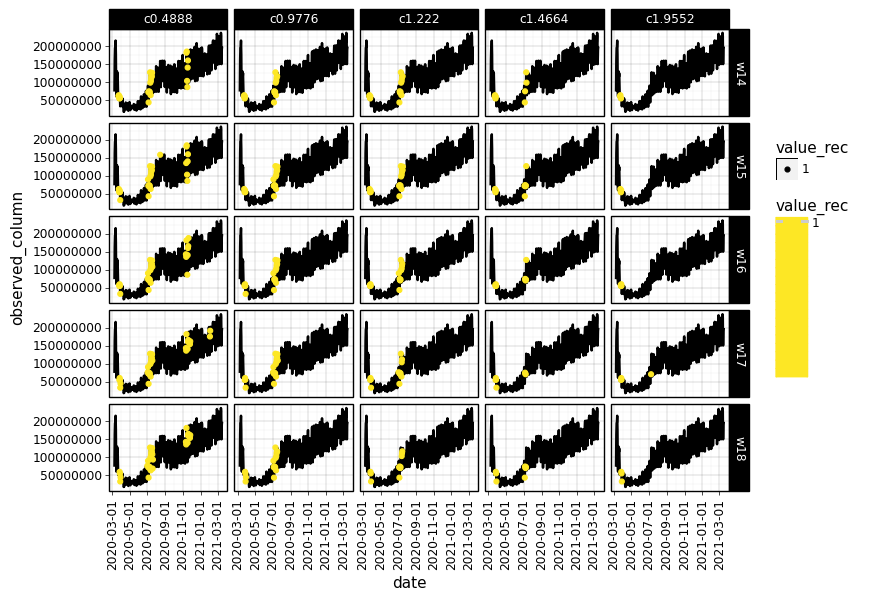

2021-03-18 00:38:27.899 | DEBUG    | __main__:_shift_level_report:102 -           date  shift_sum
91  2020-07-01        1.0
92  2020-07-02        5.0
93  2020-07-03        9.0
94  2020-07-04       11.0
95  2020-07-05       18.0
96  2020-07-06       20.0
97  2020-07-07       19.0
98  2020-07-08       19.0
99  2020-07-09       18.0
100 2020-07-10       17.0
101 2020-07-11       14.0
102 2020-07-12       13.0
103 2020-07-13       15.0
104 2020-07-14       15.0
105 2020-07-15       14.0
106 2020-07-16       12.0
107 2020-07-17        9.0
108 2020-07-18        4.0
109 2020-07-19        1.0
110 2020-07-20        1.0
135 2020-08-14        1.0
224 2020-11-11        3.0
225 2020-11-12        4.0
226 2020-11-13        5.0
227 2020-11-14        2.0
228 2020-11-15        2.0
229 2020-11-16        3.0
230 2020-11-17        5.0
231 2020-11-18        5.0
232 2020-11-19        3.0
233 2020-11-20        1.0
238 2020-11-25        2.0
239 2020-11-26        2.0
307 2021-02-02        1.0
308 2021-02-03    

<ggplot: (8772113888093)>


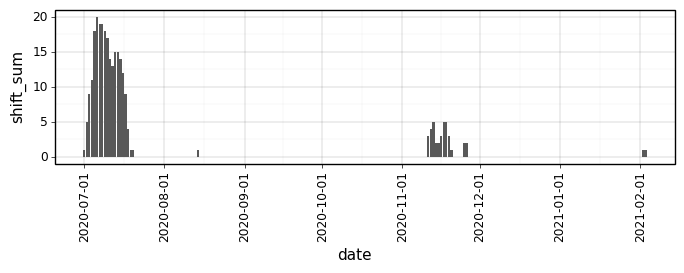

2021-03-18 00:38:28.368 | DEBUG    | __main__:_shift_level_report:112 -          date  shift_sum
96 2020-07-06       20.0


<ggplot: (8772118442869)>


In [683]:
df_run_2 = _run_step(df_run = df_run_1[['date', 'shift_1']].sort_values(by=['date']),
                     target_column_name = 'shift_1',
                     output_column_name = 'shift_2')

In [691]:
df_end = df_cty[['date', 'observed']] \
    .merge(df_run_1[['date', 'Loess', 'shift_1']].rename(columns = {'Loess':'Loess_S1'})) \
    .merge(df_run_2[['date', 'Loess', 'shift_2']].rename(columns = {'Loess':'Loess_S2'}))
df_end.head()

,date,observed,Loess_S1,shift_1,Loess_S2,shift_2
0,2020-11-06,152425044,1.524250e+08,1.524250e+08,1.211472e+08,1.211472e+08
1,2020-04-24,33724401,3.372440e+07,3.372440e+07,3.372440e+07,3.372440e+07
2,2020-07-03,90407653,9.040765e+07,9.040765e+07,9.040765e+07,9.040765e+07
3,2020-06-19,66343654,6.634365e+07,6.634365e+07,6.634365e+07,6.634365e+07
4,2021-02-10,142054087,1.902888e+08,1.902888e+08,1.590109e+08,1.590109e+08


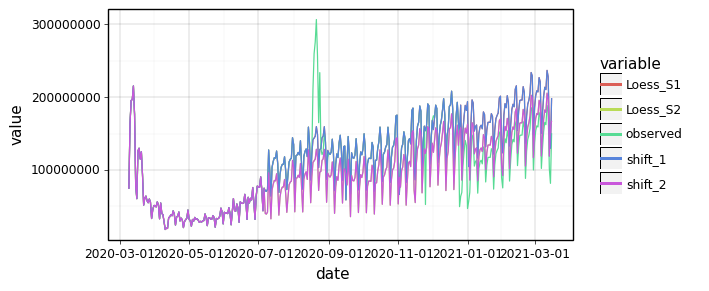

<ggplot: (8772110874569)>

In [696]:
(df_end 
>> gather('variable', 'value', -_.date)
>> p9.ggplot(p9.aes(x = 'date', y = 'value', color = 'variable'))
 + p9.geom_line()
 + p9.theme(figure_size = (6, 3))
)